There are several suites that can be used:
* Gym
* Deepmind control
* for more check the github repo

In [1]:
!gpustat

mercury              Fri Dec 11 01:28:51 2020  450.66
[0] TITAN V          | 45'C,   0 % |     6 / 12066 MB | root(4M)


In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
import os

from train_utils import *
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [3]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment & Agent

In [4]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

/s/chopin/a/grad/atercan/researchvenv/lib64/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
train_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
eval_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))

In [56]:
fc_layer_params = (40, 20)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [57]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [8]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Replay Buffer


In [9]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Training the agent


In [10]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 12.647153854370117
step = 400: loss = 26.14370346069336
step = 600: loss = 24.793594360351562
step = 800: loss = 11.693002700805664
step = 1000: loss = 20.381528854370117
step = 1000: Average Return = 33.099998474121094
step = 1200: loss = 92.40422821044922
step = 1400: loss = 12.707183837890625
step = 1600: loss = 68.1843032836914
step = 1800: loss = 8.57526969909668
step = 2000: loss = 112.09485626220703
step = 2000: Average Return = 59.0
step = 2200: loss = 10.101286888122559
step = 2400: loss = 14.861035346984863
step = 2600: loss = 28.763675689697266
step = 2800: loss = 12.836272239685059
step = 3000: loss = 11.262517929077148
step = 3000: Average Return = 117.19999694824219
step = 3200: loss = 63.52561569213867
step = 3400: loss = 

## Visualization


(-0.34000020027160716, 250.0)

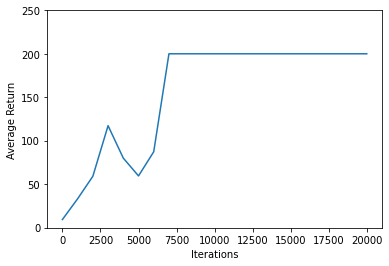

In [12]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

# Optimization

In [13]:
# from tensorflow import keras

# from tensorflow.keras.preprocessing import image_dataset_from_directory

import tempfile
from tf_agents.utils import common
import copy
from tensorflow import keras
from clustering import cluster
import distillation
import compression_utils
import tensorflow_model_optimization as tfmot


In [14]:
baseline_model_accuracy = compute_avg_return(eval_env,agent.policy,num_episodes=20)
print('Baseline test performance:', baseline_model_accuracy)
agent._q_network.summary()

Baseline test performance: 200.0
Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  1020      
_________________________________________________________________
dense_2 (Dense)              multiple                  42        
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


In [15]:
original_weights = copy.deepcopy(agent._q_network.get_weights())

In [16]:
# np.save("working_qagent_weights", original_weights, allow_pickle=True)
original_weights = np.load("working_qagent_weights.npy", allow_pickle=True)

## Clustering via KL Distillation

In [17]:
layers = agent._q_network.layers[0].layers + agent._q_network.layers[1:]
model = keras.Sequential(layers)
model.build(train_env.reset().observation.shape)
model.set_weights(original_weights)
model.summary()
compression_utils.get_compressed_size(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (1, 4)                    0         
_________________________________________________________________
dense (Dense)                (1, 40)                   200       
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   820       
_________________________________________________________________
dense_2 (Dense)              (1, 2)                    42        
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


6081

In [18]:
copied_model = keras.models.clone_model(model)
copied_model.set_weights(model.get_weights())
student = copied_model

In [19]:
student_clustered = cluster(student, n_clusters=2, verbose=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_flatten (ClusterWeig (1, 4)                    0         
_________________________________________________________________
cluster_dense (ClusterWeight (1, 40)                   202       
_________________________________________________________________
cluster_dense_1 (ClusterWeig (1, 20)                   822       
_________________________________________________________________
cluster_dense_2 (ClusterWeig (1, 2)                    44        
Total params: 1,068
Trainable params: 68
Non-trainable params: 1,000
_________________________________________________________________


In [20]:
distillation.KL_Distillation(student_clustered, agent._q_network, dataset, agent._as_transition, epochs = 2, verbose=1)

/tmp/tmp3b_2h6qq.py:30: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  network_has_state = ag__.and_((lambda : (ag__.ld(network_state) is not None)), (lambda : ag__.and_((lambda : (ag__.ld(network_state) is not ())), (lambda : (ag__.ld(network_state) is not [])))))


Epoch 1/2
2500/2500 [==============================] - 8s 3ms/step - loss: 2.8824 - accuracy: 0.7713
Epoch 2/2
2500/2500 [==============================] - 8s 3ms/step - loss: 2.8427 - accuracy: 0.7742


In [21]:
final_model = tfmot.clustering.keras.strip_clustering(student_clustered)

In [22]:
compression_utils.get_compressed_size(student)

2136

In [24]:
print(compute_avg_return(eval_env,agent.policy,num_episodes=40))
for index in range(len(agent._q_network.variables)):
    agent._q_network.variables[index].assign(student.get_weights()[index])
print(compute_avg_return(eval_env,agent.policy,num_episodes=40))

200.0
102.025


## Cluster via MSE Distillation

In [25]:
layers = agent._q_network.layers[0].layers + agent._q_network.layers[1:]
model = keras.Sequential(layers)
model.build(train_env.reset().observation.shape)
model.set_weights(original_weights)
model.summary()
compression_utils.get_compressed_size(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (1, 4)                    0         
_________________________________________________________________
dense (Dense)                (1, 40)                   200       
_________________________________________________________________
dense_1 (Dense)              (1, 20)                   820       
_________________________________________________________________
dense_2 (Dense)              (1, 2)                    42        
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


6086

In [26]:
copied_model = keras.models.clone_model(model)
copied_model.set_weights(model.get_weights())
student = copied_model

In [27]:
student_clustered = cluster(student, n_clusters=2, verbose=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_flatten (ClusterWeig (1, 4)                    0         
_________________________________________________________________
cluster_dense (ClusterWeight (1, 40)                   202       
_________________________________________________________________
cluster_dense_1 (ClusterWeig (1, 20)                   822       
_________________________________________________________________
cluster_dense_2 (ClusterWeig (1, 2)                    44        
Total params: 1,068
Trainable params: 68
Non-trainable params: 1,000
_________________________________________________________________


In [28]:
distillation.MSE_Distillation(student_clustered, agent._q_network, dataset, agent._as_transition, epochs = 2, verbose=1)

Epoch 1/2


2500/2500 [==============================] - 8s 3ms/step - loss: 5860938240.0000 - accuracy: 0.7742
Epoch 2/2
2500/2500 [==============================] - 8s 3ms/step - loss: 5645583360.0000 - accuracy: 0.7739


In [29]:
final_model = tfmot.clustering.keras.strip_clustering(student_clustered)

In [30]:
compression_utils.get_compressed_size(student)

2135

In [31]:
print(compute_avg_return(eval_env,agent.policy,num_episodes=20))
for index in range(len(agent._q_network.variables)):
    agent._q_network.variables[index].assign(student.get_weights()[index])
print(compute_avg_return(eval_env,agent.policy,num_episodes=20))

200.0
100.55


## Cluster via Online Training

In [88]:
layers = agent._q_network.layers[0].layers + agent._q_network.layers[1:]
model = keras.Sequential(layers)
model.build(train_env.reset().observation.shape)
model.set_weights(original_weights)
model.summary()
compression_utils.get_compressed_size(model)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (1, 4)                    0         
_________________________________________________________________
dense_6 (Dense)              (1, 40)                   200       
_________________________________________________________________
dense_7 (Dense)              (1, 20)                   820       
_________________________________________________________________
dense_8 (Dense)              (1, 2)                    42        
Total params: 1,062
Trainable params: 1,062
Non-trainable params: 0
_________________________________________________________________


6077

In [89]:
copied_model = keras.models.clone_model(model)
copied_model.set_weights(model.get_weights())
student = copied_model

In [90]:
student_clustered = cluster(student, n_clusters=2, verbose=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_flatten_2 (ClusterWe (1, 4)                    0         
_________________________________________________________________
cluster_dense_6 (ClusterWeig (1, 40)                   202       
_________________________________________________________________
cluster_dense_7 (ClusterWeig (1, 20)                   822       
_________________________________________________________________
cluster_dense_8 (ClusterWeig (1, 2)                    44        
Total params: 1,068
Trainable params: 68
Non-trainable params: 1,000
_________________________________________________________________


In [91]:
from tfagents_wrappers import QNetWrapper
target_model = tf.keras.models.clone_model(student_clustered)
target_model.set_weights(student_clustered.get_weights())

clustered_qnet = QNetWrapper(student_clustered,
                                  train_env.observation_spec(),
                                  train_env.action_spec())

target_qnet = QNetWrapper(target_model,
                                  train_env.observation_spec(),
                                  train_env.action_spec())

In [92]:
train_step_counter = tf.Variable(0)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

clustered_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=clustered_qnet,
    target_q_network=target_qnet,
    target_update_period=2000,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

clustered_agent.initialize()

In [93]:
compute_avg_return(eval_env, clustered_agent.policy, 20)

107.5

In [94]:
training_scripts3.offline_training(clustered_agent, eval_env, iterator)

step = 500: Average Return = 107.05000305175781
step = 1000: Average Return = 132.85000610351562
step = 1500: Average Return = 157.85000610351562
step = 2000: Average Return = 176.60000610351562


176.6

In [82]:
training_scripts.online_training(clustered_agent, train_env, eval_env, replay_buffer, iterator)

step = 500: Average Return = 110.5999984741211
step = 1000: Average Return = 157.9499969482422
step = 1500: Average Return = 159.10000610351562
step = 2000: Average Return = 147.89999389648438


147.9

In [96]:
student = tfmot.clustering.keras.strip_clustering(clustered_agent._q_network.network)

In [97]:
print(compute_avg_return(eval_env,agent.policy,num_episodes=20))
for index in range(len(agent._q_network.variables)):
    agent._q_network.variables[index].assign(student.get_weights()[index])
print(compute_avg_return(eval_env,agent.policy,num_episodes=20))

200.0
134.6


In [98]:
compression_utils.get_compressed_size(student)

2138

## Try Sequential Model with Using layers of `_q_network`

Create a model from layers, then create a clone of this. Do the learning on that and update the variables of agent manually.

### Create Sequential Model

In [32]:
for index in range(len(agent._q_network.variables)):
    agent._q_network.variables[index].assign(original_weights[index])

### Clone Model

In [347]:
_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(model, clustered_keras_file, 
                           include_optimizer=False)

Saving clustered model to:  /tmp/tmppplq53lo.h5


In [348]:
clustered_tflite_file = '/tmp/clustered_mnist.tflite'


INFO:tensorflow:Assets written to: /tmp/tmpd1yc1zrh/assets


INFO:tensorflow:Assets written to: /tmp/tmpd1yc1zrh/assets


Saved clustered TFLite model to: /tmp/clustered_mnist.tflite


In [349]:
clustered_tflite_default_file = '/tmp/clustered_mnist_default.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_clustered_model = converter.convert()
with open(clustered_tflite_default_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_default_file)

INFO:tensorflow:Assets written to: /tmp/tmpzzzqufra/assets


INFO:tensorflow:Assets written to: /tmp/tmpzzzqufra/assets


Saved clustered TFLite model to: /tmp/clustered_mnist_default.tflite


In [351]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered Keras model: %.2f bytes" % (get_gzipped_model_size(clustered_keras_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size(clustered_tflite_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size(clustered_tflite_default_file)))

Size of gzipped baseline Keras model: 4319.00 bytes
Size of gzipped clustered Keras model: 2176.00 bytes
Size of gzipped clustered TFlite model: 1314.00 bytes
Size of gzipped clustered TFlite model: 1334.00 bytes


# Test via 3 different distillation techniques

## MSE Distillation

### Create Sequential Model

In [352]:
for index in range(len(agent._q_network.variables)):
    agent._q_network.variables[index].assign(original_weights[index])

layers = agent._q_network.layers[0].layers + agent._q_network.layers[1:]

model = keras.Sequential(layers)

model.build(train_env.reset().observation.shape)
model.summary()

assert sum([np.sum(layer) for layer in original_weights]) == sum([np.sum(layer) for layer in agent._q_network.get_weights()])

copied_model = keras.models.clone_model(model)
copied_model.set_weights(model.get_weights())
legacy_model = model
model = copied_model

compute_avg_return(eval_env,agent.policy)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (1, 4)                    0         
_________________________________________________________________
dense (Dense)                (1, 100)                  500       
_________________________________________________________________
dense_1 (Dense)              (1, 2)                    202       
Total params: 702
Trainable params: 702
Non-trainable params: 0
_________________________________________________________________


200.0

In [353]:
_, keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, 
                           include_optimizer=False)

Saving clustered model to:  /tmp/tmpvb_yxkdh.h5


### Add Softmax with Temperature to the model

In [354]:
# class Temperatured_softmax(keras.layers.Layer):
#     def __init__(self, temperature=1,**kwargs):
#         super(Temperatured_softmax, self).__init__(**kwargs)
#         self.softmax = keras.layers.Softmax()
#         self.temperature = temperature

#     def call(self, inputs,training=None):
#         if training:
#             return self.softmax(tf.divide(inputs, self.temperature))
#         else:
#             return inputs
#     def get_config(self):
#         config = super(Temperatured_softmax, self).get_config()
#         config.update({"temperature": self.temperature})
#         return config
    
# model.add(Temperatured_softmax(temperature=1))


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cluster_flatten (ClusterWeig (1, 4)                    0         
_________________________________________________________________
cluster_dense (ClusterWeight (1, 100)                  504       
_________________________________________________________________
cluster_dense_1 (ClusterWeig (1, 2)                    206       
Total params: 710
Trainable params: 110
Non-trainable params: 600
_________________________________________________________________


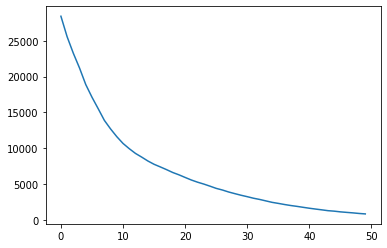

In [355]:
import tensorflow_model_optimization as tfmot

softmaxed_model = model
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 4,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# # Cluster a whole model
# clustered_model = cluster_weights(model, **clustering_params)
def skip_softmax(layer):
    if 'temperature' in layer._name:
        return layer
    else:
        return cluster_weights(layer, **clustering_params)

# Use `tf.keras.models.clone_model` to apply `apply_clustering_to_dense` 
# to the layers of the model.
clustered_model = tf.keras.models.clone_model(
    softmaxed_model,
    clone_function=skip_softmax,
)
# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.MeanSquaredError(),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()
hist = clustered_model.fit(q_dataset, #batch_size=batch_size,
                  epochs=50,
                      steps_per_epoch = 80000//32,
                   verbose = 0)
plt.plot(hist.history['loss'])

In [356]:
final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

In [358]:
for i in range(len(agent._q_network.get_weights())):
    print(agent._q_network.get_weights()[i].shape)
    a = set()
    for elem in agent._q_network.get_weights()[i].flatten():
        a.add(elem)
    print(len(a))

(4, 100)
4
(100,)
100
(100, 2)
4
(2,)
2


In [357]:
print(compute_avg_return(eval_env,agent.policy,num_episodes=10))
for index in range(len(agent._q_network.variables)):
    agent._q_network.variables[index].assign(model.get_weights()[index])
print(compute_avg_return(eval_env,agent.policy,num_episodes=10))

200.0
121.1


In [361]:
print(agent.collect_policy._greedy_policy._wrapped_policy._q_network is agent.policy._wrapped_policy._q_network)
print(agent.collect_policy._greedy_policy._wrapped_policy._q_network is agent._q_network)
print(sum([np.sum(layer) for layer in agent.collect_policy._greedy_policy._wrapped_policy._q_network.get_weights()]))
print(sum([np.sum(layer) for layer in agent.policy._wrapped_policy._q_network.get_weights()]))
print(sum([np.sum(layer) for layer in model.get_weights()]))
print(sum([np.sum(layer) for layer in final_model.get_weights()]))


_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(model, clustered_keras_file, 
                           include_optimizer=False)

clustered_tflite_file = '/tmp/clustered_mnist.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

clustered_tflite_default_file = '/tmp/clustered_mnist_default.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_clustered_model = converter.convert()
with open(clustered_tflite_default_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_default_file)

def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered Keras model: %.2f bytes" % (get_gzipped_model_size(clustered_keras_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size(clustered_tflite_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size(clustered_tflite_default_file)))

True
True
375.19369769096375
375.19369769096375
375.19369769096375
375.19369769096375
Saving clustered model to:  /tmp/tmp336x1nfi.h5
INFO:tensorflow:Assets written to: /tmp/tmpqr_yn19h/assets


INFO:tensorflow:Assets written to: /tmp/tmpqr_yn19h/assets


Saved clustered TFLite model to: /tmp/clustered_mnist.tflite
INFO:tensorflow:Assets written to: /tmp/tmpiprj_qm1/assets


INFO:tensorflow:Assets written to: /tmp/tmpiprj_qm1/assets


Saved clustered TFLite model to: /tmp/clustered_mnist_default.tflite
Size of gzipped baseline Keras model: 4320.00 bytes
Size of gzipped clustered Keras model: 2187.00 bytes
Size of gzipped clustered TFlite model: 1329.00 bytes
Size of gzipped clustered TFlite model: 1348.00 bytes
